# Averaged Prediction over entire cohort

In [1]:
import pandas as pd
import yaml
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True, errors='ignore')
df = df.groupby('city_country').filter(lambda x: len(x) > 30)
features = config['feature_columns']

Shape of SHAP values: (725, 10, 3)
Mean SHAP values for class ALL:
Fibrinogen_g_L: -0.14403453469276428
MCV_fL: 0.210160031914711
Monocytes_percent: -0.20889222621917725
LDH_UI_L: 0.006848100572824478
PT_percent: -0.04210858419537544
MCHC_g_L: 0.01663222536444664
Lymphocytes_G_L: 0.014209531247615814
age: 0.1177680566906929
Monocytes_G_L: -0.04378458857536316
Platelets_G_L: 0.0294884592294693
Mean SHAP values for class AML:
Fibrinogen_g_L: -0.08304280042648315
MCV_fL: -0.39237114787101746
Monocytes_percent: 0.2538006603717804
LDH_UI_L: 0.016897423192858696
PT_percent: 8.174694085028023e-05
MCHC_g_L: -0.01433508936315775
Lymphocytes_G_L: -0.04037131369113922
age: -0.5459003448486328
Monocytes_G_L: 0.10717868059873581
Platelets_G_L: -0.002951054135337472
Mean SHAP values for class APL:
Fibrinogen_g_L: 0.0013321732403710485
MCV_fL: -0.007677716668695211
Monocytes_percent: -0.03269683197140694
LDH_UI_L: 0.006121217738837004
PT_percent: -0.21439704298973083
MCHC_g_L: -0.11335249245166779
Ly

Summary plot for class ALL:


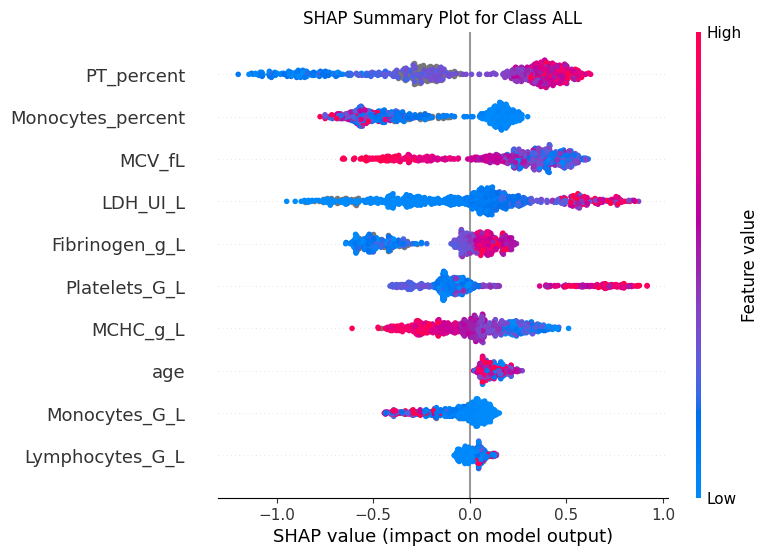

Summary plot for class AML:


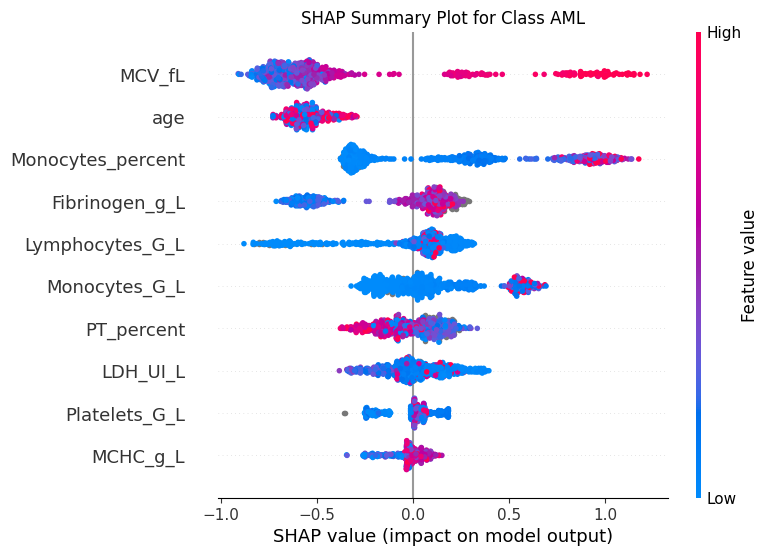

Summary plot for class APL:


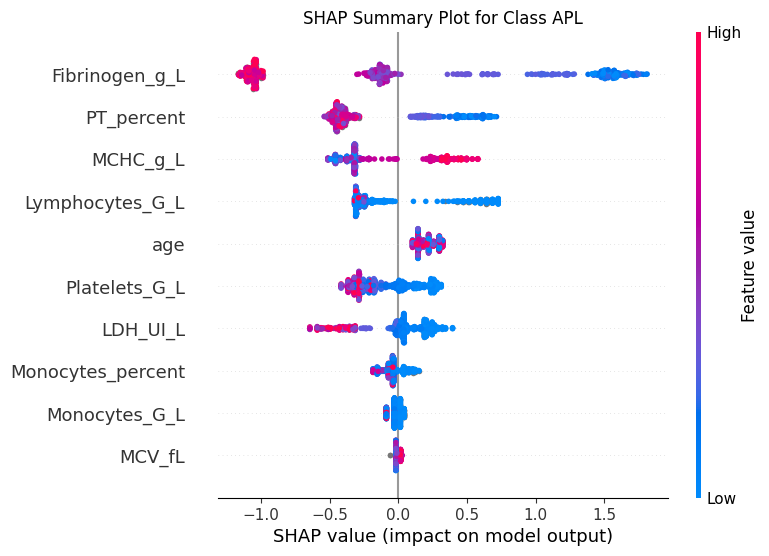

In [2]:
import xgboost as xgb
import shap
import numpy as np
import matplotlib.pyplot as plt


# Load the XGBoost model
model = xgb.Booster(model_file='model.json')

# Calculate Monocytes_percent for each row in the DataFrame
df['mono_percent'] = (df['Monocytes_G_L'] * 100) / df['WBC_G_L']

data_for_prediction = df[features]
dtest = xgb.DMatrix(data_for_prediction)
predictions = model.predict(dtest)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)
print("Shape of SHAP values:", np.shape(shap_values))

# Aggregate SHAP values by taking the mean over all samples for each class
mean_shap_values = np.mean(shap_values, axis=0)
class_name = {0: 'ALL', 1: 'AML', 2: 'APL'}

# Print the mean SHAP values for each feature by class
for class_index in range(mean_shap_values.shape[1]):
    print(f"Mean SHAP values for class {class_name[class_index]}:")
    for feature_index, feature_name in enumerate(features):
        print(f"{feature_name}: {mean_shap_values[feature_index, class_index]}")

# Init the JavaScript visualization library
shap.initjs()

# Generate summary plots for each class
for class_index in range(mean_shap_values.shape[1]):
    print(f"Summary plot for class {class_name[class_index]}:")
    shap.summary_plot(shap_values[:, :, class_index], data_for_prediction, show=False)
    plt.title(f"SHAP Summary Plot for Class {class_name[class_index]}")
    plt.show()

# Prediction by samples & class

In [3]:
import pandas as pd
import xgboost as xgb
import shap
import numpy as np

# Load the dataset
df = pd.read_csv('/local/work/merengelke/aipal/rome/aipal/predict.csv')

# Load the XGBoost model
model = xgb.Booster(model_file='model.json')

# Features relevant for prediction in the dataset
# Column names in the sample_data DataFrame
features = [
    'MCV_fL',
    'PT_percent',
    'LDH_UI_L',
    'MCHC_g_L',
    'WBC_G_L',
    'Fibrinogen_g_L',
    'Monocytes_G_L',
    'Platelets_G_L',
    'Lymphocytes_G_L',
    'age'
]

# Calculate Monocytes_percent for each row in the DataFrame
df['mono_percent'] = (df['Monocytes_G_L'] * 100) / df['WBC_G_L']

# Select the relevant columns for prediction
data_for_prediction = df[features]

# Convert the DataFrame to DMatrix
dtest = xgb.DMatrix(data_for_prediction)

# Predict using the model
predictions = model.predict(dtest)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)

# Print the SHAP values for the first prediction as an example
print("SHAP values for the first prediction (class 0):\n", shap_values[0][:, 0])

# Plot the SHAP values for the first prediction as an example
shap.initjs()

# Check the shape of the SHAP values
print("Shape of SHAP values:", np.shape(shap_values))

# Generate the force plot for the first prediction for class 0
if isinstance(explainer.expected_value, list):
    expected_value = explainer.expected_value[0]
else:
    expected_value = explainer.expected_value

# Select SHAP values for class 0
shap_values_class_0 = shap_values[:, :, 0]

# Generate the force plot for the first prediction
shap.force_plot(expected_value, shap_values_class_0[0], data_for_prediction.iloc[0])



SHAP values for the first prediction (class 0):
 [ 0.10766493  0.41810632 -0.7252914   0.10291347  0.4272954   0.25450674
  0.01633389  0.11719495 -0.4409688  -0.03627499]


Shape of SHAP values: (116, 10, 3)
